# Neural Network - LSTM

In [44]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import RenewAI
sys.path.append('/Users/tmorales/tmp/RNN-windPower/src')
from pre_process.split_ml_ts import dataframe_split

In [30]:
exp_path = '/Users/tmorales/tmp/experiments/NREL/Offshore_WA_OR/turbine_25915'
experiment_name = 'nn-lstm'
directory = os.path.join(exp_path, experiment_name)
if not os.path.exists(directory):
    os.makedirs(directory)

## Load file

In [31]:
path = '/Users/tmorales/tmp/RNN-windPower/database/wind_farms/Offshore_WA_OR/Offshore_WA_OR_features'

In [32]:
os.chdir(path)
files = [file for file in glob.glob('Offshore_WA_OR_features_*.csv')]
files

['Offshore_WA_OR_features_h_01.csv',
 'Offshore_WA_OR_features_h_02.csv',
 'Offshore_WA_OR_features_h_03.csv',
 'Offshore_WA_OR_features_h_04.csv',
 'Offshore_WA_OR_features_h_05.csv',
 'Offshore_WA_OR_features_h_06.csv',
 'Offshore_WA_OR_features_h_07.csv',
 'Offshore_WA_OR_features_h_08.csv',
 'Offshore_WA_OR_features_h_09.csv',
 'Offshore_WA_OR_features_h_10.csv',
 'Offshore_WA_OR_features_h_11.csv',
 'Offshore_WA_OR_features_h_12.csv',
 'Offshore_WA_OR_features_h_13.csv',
 'Offshore_WA_OR_features_h_14.csv',
 'Offshore_WA_OR_features_h_15.csv',
 'Offshore_WA_OR_features_h_16.csv',
 'Offshore_WA_OR_features_h_17.csv',
 'Offshore_WA_OR_features_h_18.csv',
 'Offshore_WA_OR_features_h_19.csv',
 'Offshore_WA_OR_features_h_20.csv',
 'Offshore_WA_OR_features_h_21.csv',
 'Offshore_WA_OR_features_h_22.csv',
 'Offshore_WA_OR_features_h_23.csv',
 'Offshore_WA_OR_features_h_24.csv']

## Paso 1: only one h-step

In [33]:
h1 = files[0]

In [34]:
# create directory for each horizont (each horizon is a regressor)
horizont = 1
directory_by_horizont = os.path.join(exp_path, 
                                     experiment_name,
                                     'model_saved_h={0:03d}'.format(horizont))
if not os.path.exists(directory_by_horizont):
    os.makedirs(directory_by_horizont)

In [35]:
# load file
df_h1 = pd.read_csv(files[0], delimiter=';', index_col=0)
df_h1.head(4)

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1
target_date,,,,,,,
2004-01-01 06:00:00,6.96,5.28,5.32,4.93,4.05,3.95,4.19
2004-01-01 07:00:00,5.28,5.32,4.93,4.05,3.95,4.19,4.89
2004-01-01 08:00:00,5.32,4.93,4.05,3.95,4.19,4.89,5.16
2004-01-01 09:00:00,4.93,4.05,3.95,4.19,4.89,5.16,5.01


In [36]:
# select the best model for h=1

# split the dataset in train, val and test
data = dataframe_split(df_h1)
train_set = data['train_set']
validation_set = data['validation_set']
test_set = data['test_set']

In [37]:
# features and target columns
features_columns = train_set.columns[1:-1]
target_column = train_set.columns[-1:]

In [48]:
# select the values of features and target columns.
features_train_set = train_set[features_columns]
target_train_set = train_set[target_column]
features_validation_set = validation_set[features_columns]
target_validation_set = validation_set[target_column]
features_test_set = test_set[features_columns]
target_test_set = test_set[target_column]

In [62]:
# select values
x_train = features_train_set.values.astype('float32')
y_train = target_train_set.values
x_val = features_validation_set.values.astype('float32')
y_val = target_validation_set.values

In [40]:
print('N of examples: {0}'.format(x_train.shape))

N of examples: (16830, 5)


In [41]:
x_train.max()

22.25

## Paso 2: Model defenition

In [80]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model

In [52]:
# reshape the data for training LSTM
print(x_train.shape)
x_train_lstm = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train_lstm.shape)

x_val_lstm = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test_lstm = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

(16830, 5)
(16830, 5, 1)


In [158]:
def create_model(time_step, feature_by_timestep,
                 plot_title):
    # Input layer
    input = Input((time_step,
                   feature_by_timestep),
                   dtype='float32',
                   name='input-layer')
    normalize_input = BatchNormalization(name='normalize-input')(input)
    # RNN - LSTM
    x = LSTM(10, name='lstm-layer')(normalize_input)
    # Fully-connect
    x = Dense(10,
              kernel_initializer='normal',
              activation='relu',
              name='hidden-layer-1')(x)
    x = Dense(5, 
              kernel_initializer='normal', 
              activation='relu',
              name='hidden-layer-2')(x)
    x = Dense(3,
              kernel_initializer='normal',
              activation='relu',
              name='hidden-layer-3')(x)
    #x = Dropout(rate=0.2)(x)
    output = Dense(1, 
                   kernel_initializer='normal', 
                   activation='linear',
                   name='output-layer')(x)
    # Model
    model = Model(inputs=input, outputs=output)
    model.summary()
    
    plot_model(model,
               to_file='{0}.png'.format(plot_title),
               show_shapes=True,
               show_layer_names=True,
               rankdir='LR')
    
    return model

In [159]:
def fit_model(model, x_train, y_train, x_val, y_val, 
              epochs=100, batch_size=50, lr=0.001):
    
    opt = Adam(lr=lr)
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['mae'])
    
    history = model.fit(x_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val))
    
    return model, history

In [160]:
model = create_model(5, 1, plot_title='lstm')
model, history = fit_model(model, x_train_lstm, y_train, x_val_lstm, y_val,
                           batch_size=1024, epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input-layer (InputLayer)     (None, 5, 1)              0         
_________________________________________________________________
normalize-input (BatchNormal (None, 5, 1)              4         
_________________________________________________________________
lstm-layer (LSTM)            (None, 10)                480       
_________________________________________________________________
hidden-layer-1 (Dense)       (None, 10)                110       
_________________________________________________________________
hidden-layer-2 (Dense)       (None, 5)                 55        
_________________________________________________________________
hidden-layer-3 (Dense)       (None, 3)                 18        
_________________________________________________________________
output-layer (Dense)         (None, 1)                 4         
Total para

Epoch 89/100
16830/16830 [==============================] - 0s 13us/step - loss: 0.8814 - mean_absolute_error: 0.6300 - val_loss: 0.7985 - val_mean_absolute_error: 0.6125
Epoch 90/100
16830/16830 [==============================] - 0s 13us/step - loss: 0.8891 - mean_absolute_error: 0.6374 - val_loss: 0.7979 - val_mean_absolute_error: 0.6126
Epoch 91/100
16830/16830 [==============================] - 0s 19us/step - loss: 0.8819 - mean_absolute_error: 0.6306 - val_loss: 0.8059 - val_mean_absolute_error: 0.6158
Epoch 92/100
16830/16830 [==============================] - 0s 13us/step - loss: 0.8858 - mean_absolute_error: 0.6352 - val_loss: 0.7949 - val_mean_absolute_error: 0.6111
Epoch 93/100
16830/16830 [==============================] - 0s 15us/step - loss: 0.8790 - mean_absolute_error: 0.6309 - val_loss: 0.7961 - val_mean_absolute_error: 0.6119
Epoch 94/100
16830/16830 [==============================] - 0s 15us/step - loss: 0.8773 - mean_absolute_error: 0.6277 - val_loss: 0.8017 - val_me

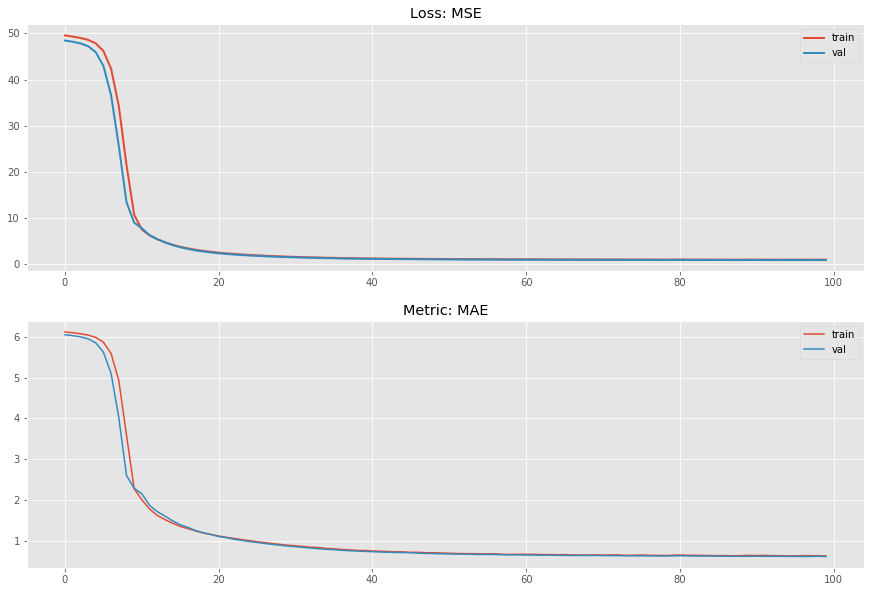

In [161]:
f, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))
ax1.plot(history.history['loss'], lw=2, label='train')
ax1.plot(history.history['val_loss'], lw=2, label='val')
ax1.set_title('Loss: MSE')
ax1.legend()
ax2.plot(history.history['mean_absolute_error'], label='train')
ax2.plot(history.history['val_mean_absolute_error'], label='val')
ax2.set_title('Metric: MAE')
ax2.legend()

## Paso 3: Prediction

In [162]:
x_test = features_test_set.values.astype('float32')
x_test_lstm = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test_lstm.shape

(5260, 5, 1)

In [163]:
predicted = model.predict(x_test_lstm)

In [164]:
df_prediction = test_set.copy()
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1
target_date,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00


In [165]:
df_prediction = test_set.copy()
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1
target_date,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00


In [166]:
df_prediction['target_predicted'] = predicted
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1,target_predicted
target_date,,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19,3.852135
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60,4.271173
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34,4.732131
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70,5.578436
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00,4.583254


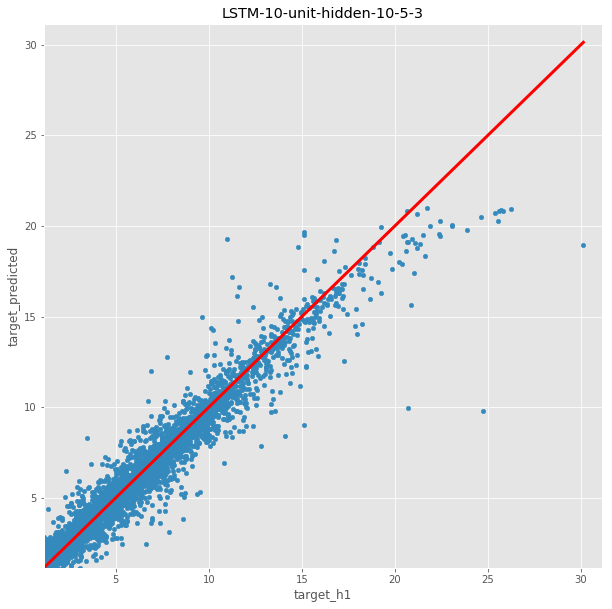

In [169]:
#title='LSTM-10-unit_hidden-5'
title='LSTM-10-unit-hidden-10-5-3'

f, ax = plt.subplots(1,1,figsize=(10,10))
x_min = df_prediction.target_h1.min() 
x_max = df_prediction.target_h1.max()
y_min = df_prediction.target_predicted.min()
y_max = df_prediction.target_predicted.max()
ax.set_title(title)
# line
ax.set_xlim(x_min+1, x_max+1)
ax.set_ylim(x_min+1, x_max+1)
ax.plot((x_min, x_max), (x_min, x_max), lw=3, c='r')
# scatter
df_prediction.plot(ax=ax,
                   x='target_h1',
                   y='target_predicted',
                   kind='scatter',
                  )

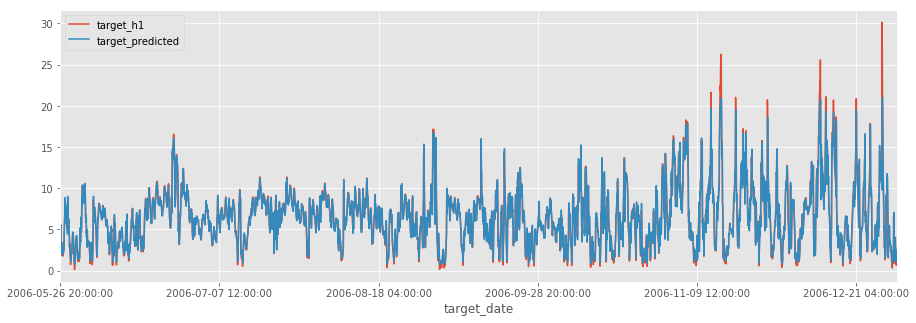

In [168]:
df_prediction.iloc[:,-2:].plot(figsize=(15,5))

In [170]:
 df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1,target_predicted
target_date,,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19,3.852135
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60,4.271173
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34,4.732131
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70,5.578436
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00,4.583254


In [171]:
df_prediction['mse_h1'] = np.power(df_prediction.target_h1 -
                                   df_prediction.target_predicted, 2)

In [172]:
df_prediction['mae_h1'] = np.abs(df_prediction.target_h1 - 
                                 df_prediction.target_predicted)

In [173]:
# write on disk
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1,target_predicted,mse_h1,mae_h1
target_date,,,,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19,3.852135,0.114153,0.337865
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60,4.271173,0.108127,0.328827
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34,4.732131,0.369505,0.607869
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70,5.578436,0.771650,0.878436
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00,4.583254,2.506693,1.583254


In [174]:
test_mse = df_prediction.mse_h1.sum() / len(df_prediction.mse_h1)
test_mse

0.8167876982808187

In [175]:
test_mae = df_prediction.mae_h1.sum() / len(df_prediction.mae_h1)
test_mae

0.5562301339160354